In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt


# model
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


# Part 1: Exploratory Social Network Analysis [30 Points]

### 3. Perform some basic network analyses and briefly explain each of your findings [30 points]:


(a) Load the directed network graph (G) from the file amazonNetwork.csv. [2 points]

In [2]:
amazon_df = pd.read_csv('amazonNetwork.csv')
print("Number of rows: {}, Number of columns: {}".format(amazon_df.shape[0], amazon_df.shape[1]))
amazon_df.head()

Number of rows: 10841, Number of columns: 2


,FromNodeId,ToNodeId
0,1,2
1,1,4
2,1,5
3,1,15
4,2,11


In [3]:
G = nx.from_pandas_edgelist(amazon_df, source='FromNodeId',target='ToNodeId', create_using=nx.DiGraph())
nx.is_directed(G) # check, expect 'True'

True

(b) How many items are present in the network and how many co-purchases happened? [7 points]

In [4]:
print("Number of items in the network:", G.number_of_nodes())
print("NUmber of co-purchases:", G.number_of_edges())

Number of items in the network: 2647
NUmber of co-purchases: 10841


(c) Compute the average shortest distance between the nodes in graph G. Explain your results briefly. [7 points]

In [5]:
print("Average Shortest Path Length:", round(nx.average_shortest_path_length(G), 2))

Average Shortest Path Length: 9.59


In out graph G, the average shortest distance between the nmodes is 9.59
This means to get from one node to another the shortest path possible, it need to go through 9.59 nodes.
This shows that our network is not well-connected.

(d) Compute the transitivity and the average clustering coefficient of the network graph G. Explain your findings briefly based on the definitions of clustering coefficient and transitivity. [7 points]

In [6]:
print("Transitivity:", round(nx.transitivity(G), 2))
print("Average clustering coefficient:", round(nx.average_clustering(G), 2))

Transitivity: 0.43
Average clustering coefficient: 0.41


Average clustering coefficient equals to 0.43 means the ratio of every node's neighbors that are connected to others is 0.43 on average.
Transitivity equals to 0.41 means 0.41 of the two nodes have relations that are connected by an edge.
Both Transitivity and Average clustering coefficient are not high enough, which means nodes between nodes are not well-connected.

(e) Apply the PageRank algorithm to network G with damping value 0.5 and find the
10 nodes with the highest PageRank. Explain your findings briefly.
NetworkX document of the PageRank algorithm: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html [7 points]

In [7]:
pg = nx.pagerank(G, alpha = 0.5)
pg = {k:v for k, v in sorted(pg.items(), key=lambda t: t[1], reverse=True)}

In [8]:
highest_pg = list(pg.keys())[0:10]
count = 1
for node in highest_pg:
    print("{}. {}".format(count, node))
    count += 1

1. 8
2. 481
3. 33
4. 18
5. 23
6. 30
7. 346
8. 99
9. 93
10. 21


# Part 2: Predicting Review-Rating using Features derived from network properties [50 Points]

### Load Data

In [9]:
training = pd.read_csv('reviewTrain.csv')
testing = pd.read_csv('reviewTest.csv')

### Data Preprocessing

In [10]:
print("Training set have {} unique values, which are {}.".format(training['group'].nunique(), training['group'].unique()))
print("Testing set have {} unique values, which are {}.".format(testing['group'].nunique(), testing['group'].unique()))

Training set have 5 unique values, which are [' Book' ' Music' ' DVD' ' Video' ' Toy'].
Testing set have 4 unique values, which are [' Book' ' Music' ' Video' ' DVD'].


We found that "toy" group is only in training set. Because we are not going to predict the reviews in this group, I drop the records that are in 'toy' group.

In [11]:
training = training[training['group'] != " Toy"]

In [12]:
training.groupby('review').count()

,id,title,group
review,,,
0.0,417,417,417
1.0,10,10,10
1.5,3,3,3
2.0,16,16,16
2.5,18,18,18
3.0,64,64,64
3.5,96,96,96
4.0,267,267,267
4.5,340,340,340


Since there is no case that review = 0, I tend to drop the records. 

Also, we observe most records have the review between 4.0 and 5.0 in the below dataframe, we could expect that the predict results would mostly lie in this range.

In [13]:
training = training[training['review'] != 0]

#### Feature Engineering

In [14]:
def add_feature(df):

    # transform the group feature to dummy variables
    cat_dummies = pd.get_dummies(df['group'])
    df.drop(['group'], axis=1, inplace = True)
    df = pd.concat([df, cat_dummies], axis=1)
    
    # add cluster coefficient from networkx
    cluster_coeff = nx.clustering(G)
    cluster_coeff_df = pd.DataFrame.from_dict({'id':list(cluster_coeff.keys()), 'cluster_coef':list(cluster_coeff.values())})
    combined = pd.merge(df, cluster_coeff_df, on='id', how='left').reset_index(drop=True)
    
    # add page rank from networkx
    pg_df = pd.DataFrame.from_dict({'id':list(pg.keys()), 'page_rank':list(pg.values())})
    combined = pd.merge(combined, pg_df, on='id', how='left').reset_index(drop=True)
    
    # add degree centrality from networkx
    dc = nx.degree_centrality(G)
    dc_df = pd.DataFrame.from_dict({'id':list(dc.keys()), 'degree_centrality':list(dc.values())})
    combined = pd.merge(combined, dc_df, on='id', how='left').reset_index(drop=True)

    # add closeness centralityt from networkx
    cc = nx.closeness_centrality(G)
    cc_df = pd.DataFrame.from_dict({'id':list(cc.keys()), 'closeness_centrality':list(cc.values())})
    combined = pd.merge(combined, cc_df, on='id', how='left').reset_index(drop=True)
    
    # add betweenness centrality from networkx
    bc = nx.betweenness_centrality(G)
    bc_df = pd.DataFrame.from_dict({'id':list(bc.keys()), 'betweenness_centrality':list(bc.values())})
    combined = pd.merge(combined, bc_df, on='id', how='left').reset_index(drop=True)

    return combined

In [15]:
training_df = add_feature(training)
testing_df = add_feature(testing)

In [16]:
training_df.corr()

,id,review,Book,DVD,Music,Video,cluster_coef,page_rank,degree_centrality,closeness_centrality,betweenness_centrality
id,1.000000,0.050928,0.012803,-0.004498,-0.002179,-0.018410,0.217940,-0.353181,-0.465063,-0.436476,-0.323589
review,0.050928,1.000000,-0.048142,-0.109306,0.116626,-0.012932,-0.016068,-0.031606,-0.038316,-0.023810,0.023075
Book,0.012803,-0.048142,1.000000,-0.322503,-0.775840,-0.348341,-0.018023,-0.003463,-0.010931,-0.014172,0.005150
DVD,-0.004498,-0.109306,-0.322503,1.000000,-0.114365,-0.051348,0.027253,0.016451,0.026500,0.048840,-0.011951
Music,-0.002179,0.116626,-0.775840,-0.114365,1.000000,-0.123528,0.024123,-0.009678,-0.014757,-0.006973,-0.000258
Video,-0.018410,-0.012932,-0.348341,-0.051348,-0.123528,1.000000,-0.032126,0.009665,0.025107,-0.003111,0.000880
cluster_coef,0.217940,-0.016068,-0.018023,0.027253,0.024123,-0.032126,1.000000,-0.171803,-0.123259,-0.157367,-0.268268
page_rank,-0.353181,-0.031606,-0.003463,0.016451,-0.009678,0.009665,-0.171803,1.000000,0.895854,0.400162,0.597566
degree_centrality,-0.465063,-0.038316,-0.010931,0.026500,-0.014757,0.025107,-0.123259,0.895854,1.000000,0.360077,0.544591
closeness_centrality,-0.436476,-0.023810,-0.014172,0.048840,-0.006973,-0.003111,-0.157367,0.400162,0.360077,1.000000,0.373329


From correlation matrix, it is obvious that every feature we generate(cluster_coef, page_rank, degree_centrality, closeness_centrality, betweenness_centrality) have either positive or negative correlation with the independent variable review. This means the values of these features would slightly influence the value of review. Thus, we tend to add those features in the model.

In [17]:
def extract_features(df):
    df_ = df.drop(['id', 'title'], axis = 1)
    return df_

In [18]:
training = extract_features(training_df)
testing = extract_features(testing_df)

### Prepare Data for Training, Validating, and Testing

In [19]:
X_training = training.iloc[:, 1:]
y_training = training.iloc[:, 0]

X_testing = testing.iloc[:, 1:]
y_testing = testing.iloc[:, 0]

In [20]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_training)
X_test_scaled = scaler.transform(X_testing)

In [21]:
# deal with the missing values that don't have network records in amazonNetwork.csv
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.fit_transform(X_test_scaled)

In [22]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train_imputed, y_training, test_size= 0.2, stratify=y_training)

### Model Selection

In [23]:
models = [ RidgeCV(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), xgb.XGBRegressor()]

for ml in models:
    
    ### train
    ml.fit(x_train, y_train)
    
    ### predict
    y_pred = ml.predict(x_valid)
    
    ### MAE
    print(ml, "MAE:", mean_absolute_error(y_valid, y_pred))
    
    # ### feature
    # importance = ml.feature_importances_
    # for i,v in enumerate(importance):
    #     print('Feature: %0d, Score: %.5f' % (i,v))
    #     # plot feature importance
    # plt.bar([x for x in range(len(importance))], importance)
    # plt.show()
    

RidgeCV(alphas=array([ 0.1,  1. , 10. ])) MAE: 0.5810976680173737
SVR() MAE: 0.5729324469136936
KNeighborsRegressor() MAE: 0.6142857142857143
DecisionTreeRegressor() MAE: 0.6904761904761905
RandomForestRegressor() MAE: 0.5913614537565867
GradientBoostingRegressor() MAE: 0.5880375531094428
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...) MAE: 0.64603314702472

### Hyperparameter Tuning using GridSearch

In [24]:
params = {'C': [0.1, 1, 10, 100, 1000],
          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
          'kernel': ['rbf']
          }

model = SVR()

grid_search = GridSearchCV(
    estimator = model,
    param_grid = params,
    scoring = "neg_mean_absolute_error",
)
grid_search.fit(x_train, y_train)

svr_best_params = grid_search.best_params_
print("best_parameters: ", svr_best_params)
print("best_model_score: ", grid_search.score(x_valid, y_valid))

best_parameters:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
best_model_score:  -0.5729391697167704


In [25]:
params = {'n_neighbors': [7, 11, 20],
          'weights': ['uniform', 'distance'],
          'leaf_size': [10, 30, 50, 70, 90],
          'p': [1, 2, 3, 4]
          }

model = KNeighborsRegressor()

grid_search = GridSearchCV(
    estimator = model,
    param_grid = params,
    scoring = "neg_mean_absolute_error",
)
grid_search.fit(x_train, y_train)

knn_best_params = grid_search.best_params_
print("best_parameters: ", knn_best_params)
print("best_model_score: ", grid_search.score(x_valid, y_valid))

best_parameters:  {'leaf_size': 10, 'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
best_model_score:  -0.5868055555555556


In [26]:
params = {'learning_rate': [0.1, 0.05, 0.001],
          'n_estimators': range(50, 150, 50), 
        #   'subsample': [0.8, 1], 
          # 'criterion':'friedman_mse', 
          'min_samples_split': [600, 800, 1000, 1200], 
          'min_samples_leaf': [50, 100, 150],
          # 'min_weight_fraction_leaf': 0.0, 
          'max_depth': range(3, 7, 1), # usually 5-8
          # 'min_impurity_decrease': 0.0, 
          # 'max_features':None, 
          # 'alpha':0.9, 
          # 'verbose':0, 
          # 'max_leaf_nodes':None, 
          # 'warm_start':False, 
          # 'validation_fraction':0.1, 
          # 'n_iter_no_change':None, 
          # 'tol':0.0001,
          # 'ccp_alpha':0.0
          }

model = GradientBoostingRegressor()

grid_search = GridSearchCV(
    estimator = model,
    param_grid = params,
    scoring = "neg_mean_absolute_error",
)
grid_search.fit(x_train, y_train)

gb_best_params = grid_search.best_params_
print("best_parameters: ", gb_best_params)
print("best_model_score: ", grid_search.score(x_valid, y_valid))

best_parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 150, 'min_samples_split': 600, 'n_estimators': 100}
best_model_score:  -0.5750956531068404


In [27]:
params = {#'nthread':[4, 6], #when use hyperthread, xgboost may become slower
          'objective':['reg:squarederror'],
          'learning_rate': [0.001, 0.05, 0.1], #so called `eta` value
          'max_depth': range(3, 7, 1),
            #   'min_child_weight': [4],
            #   'silent': [1],
            #   'subsample': [0.7],
            #   'colsample_bytree': [0.7],
          'n_estimators': range(50, 150, 50)
          }

model = xgb.XGBRegressor()

grid_search = GridSearchCV(
    estimator = model,
    param_grid = params,
    scoring = "neg_mean_absolute_error",
)
grid_search.fit(x_train, y_train)

xgb_best_params = grid_search.best_params_
print("best_parameters: ", xgb_best_params)
print("best_model_score: ", grid_search.score(x_valid, y_valid))

best_parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'objective': 'reg:squarederror'}
best_model_score:  -0.5837794807222154


### Final Model on Validation data

In [28]:
estimators = [
    ('lr', RidgeCV()),
    ('svr', SVR(**svr_best_params)),
    ('knn', KNeighborsRegressor(**knn_best_params)), 
    ('rf', RandomForestRegressor()),
    ('gb', GradientBoostingRegressor(**gb_best_params)), 
    ('xgb',xgb.XGBRegressor(**xgb_best_params)), 
] 

clf = StackingRegressor(
    estimators = estimators,
    final_estimator = SVR(**svr_best_params),
    cv = 3
)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_valid)
valid_store = mean_absolute_error(y_pred, y_valid)
print("Stacking MAE:", valid_store)

Stacking MAE: 0.5580953919987598


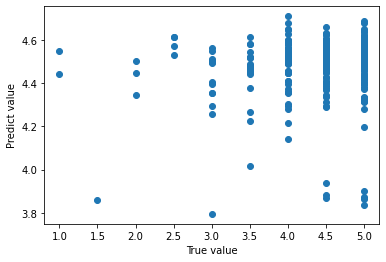

In [29]:
plt.scatter(x = y_valid, y = y_pred)
plt.xlabel("True value")
plt.ylabel("Predict value")
plt.show()

### Predicting on testing data

In [30]:
X_train = np.concatenate([x_train, x_valid], axis = 0)
Y_train = np.concatenate([y_train, y_valid], axis = 0)
clf.fit(X_train, Y_train)
results = clf.predict(X_test_imputed)

### Write to csv

In [31]:
new_testing = pd.concat([pd.DataFrame(results, columns = ["review"]), testing], axis = 1).iloc[:, :-1]

In [32]:
new_testing.to_csv('Amazon_reviews_prediction.csv')